# Project 2: Sentiment Analysis

## Part I: Bloomberg Inflation Analysis

In [90]:
from newsapi import NewsApiClient
import pandas as pd
import numpy as np
import csv

In [92]:
api = NewsApiClient(api_key='c340a28a3a8b4cb3b75c8a478d67330e')
all_articles = api.get_everything(qintitle='inflation', sources='bloomberg', from_param='2022-11-30', to='2022-12-29', language='en')
all_articles = all_articles['articles']

### Filter away Podcast and Radio & Save as csv file

In [3]:
filter_criteria = ['/audio/']
filtered_allArticles = []
for i in range(len(all_articles)):
    blocked = False
    for item in filter_criteria:
        if item in all_articles[i]['url']:
            blocked = True
            break
    if blocked == False:
        filtered_allArticles.append(all_articles[i])

In [4]:
filtered_allArticles = pd.DataFrame (filtered_allArticles, columns = ['source', 'author', 'title', 'discription', 'url', 'urlToImage', 'publishedAt', 'content'])

In [5]:
filtered_allArticles.to_csv('filtered_allArticles.csv', index=False, header=True)

## Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import re
import pickle
import nltk
import logging
import multiprocessing
from datetime import datetime
from re import sub
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
import spacy 
import stanza 
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset 

[nltk_data] Downloading package punkt to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
filtered_allArticles = pd.read_csv('filtered_allArticles.csv')
filtered_allArticles.head(3)

,source,author,title,discription,url,urlToImage,publishedAt,content,Cleaned_content,POS tagged,Lemma
0,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Simon Kennedy,'Polycrisis' Inflation,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-05T12:00:14Z,Hello. Today we look at inflation at times of ...,hello today we look at inflation at times of e...,"[('hello', 'n'), ('today', 'n'), ('look', 'v')...",hello today look inflation time economic str...
1,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,Inflation Watch,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/s3/javelin/public/javel...,2022-12-13T12:00:16Z,Hello. Today we brace for the latest US inflat...,hello today we brace for the latest us inflati...,"[('hello', 'n'), ('today', 'n'), ('brace', 'v'...",hello today brace late us inflation read exa...
2,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,An Underappreciated Inflation Loser Is Wenatch...,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-16T12:00:16Z,Hello. Today we look at the costliest US citie...,hello today we look at the costliest us cities...,"[('hello', 'n'), ('today', 'n'), ('look', 'v')...",hello today look costly us city world cup ec...


### Clean the text

In [3]:
sep = ' … '
for i in range(len(filtered_allArticles)):
    filtered_allArticles['content'][i] = filtered_allArticles['content'][i].split(sep, 1)[0]

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\3768427590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_allArticles['content'][i] = filtered_allArticles['content'][i].split(sep, 1)[0]


In [4]:
# Define a function to clean the text
def text_to_word_list(text):
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    return text

# Cleaning the text in the column
filtered_allArticles['Cleaned_content'] = filtered_allArticles['content'].apply(text_to_word_list)
filtered_allArticles.head()

,source,author,title,discription,url,urlToImage,publishedAt,content,Cleaned_content,POS tagged,Lemma
0,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Simon Kennedy,'Polycrisis' Inflation,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-05T12:00:14Z,Hello. Today we look at inflation at times of ...,hello today we look at inflation at times of e...,"[('hello', 'n'), ('today', 'n'), ('look', 'v')...",hello today look inflation time economic str...
1,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,Inflation Watch,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/s3/javelin/public/javel...,2022-12-13T12:00:16Z,Hello. Today we brace for the latest US inflat...,hello today we brace for the latest us inflati...,"[('hello', 'n'), ('today', 'n'), ('brace', 'v'...",hello today brace late us inflation read exa...
2,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,An Underappreciated Inflation Loser Is Wenatch...,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-16T12:00:16Z,Hello. Today we look at the costliest US citie...,hello today we look at the costliest us cities...,"[('hello', 'n'), ('today', 'n'), ('look', 'v')...",hello today look costly us city world cup ec...
3,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Charlie Wells,Bloomberg Wealth: Has Inflation Finally Peaked?,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-15T11:30:18Z,To the relief of consumers and policymakers al...,to the relief of consumers and policymakers al...,"[('relief', 'n'), ('consumers', 'n'), ('policy...",relief consumer policymakers alike appear in...
4,"{'id': 'bloomberg', 'name': 'Bloomberg'}","Joe Weisenthal, Tracy Alloway",Where Things Stand Now With Inflation and the Fed,NaN,https://www.bloomberg.com/news/articles/2022-1...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-19T09:00:17Z,Listen to Odd Lots on Apple PodcastsListen to ...,listen to odd lots on apple podcastslisten to ...,"[('listen', 'n'), ('odd', 'a'), ('lots', 'n'),...",listen odd lot apple podcastslisten odd lot ...


### Tokenization, Stopwords Removal, POS Tagging

In [5]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

filtered_allArticles['POS tagged'] = filtered_allArticles['Cleaned_content'].apply(token_stop_pos)
filtered_allArticles.head()

,source,author,title,discription,url,urlToImage,publishedAt,content,Cleaned_content,POS tagged,Lemma
0,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Simon Kennedy,'Polycrisis' Inflation,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-05T12:00:14Z,Hello. Today we look at inflation at times of ...,hello today we look at inflation at times of e...,"[(hello, n), (today, n), (look, v), (inflation...",hello today look inflation time economic str...
1,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,Inflation Watch,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/s3/javelin/public/javel...,2022-12-13T12:00:16Z,Hello. Today we brace for the latest US inflat...,hello today we brace for the latest us inflati...,"[(hello, n), (today, n), (brace, v), (latest, ...",hello today brace late us inflation read exa...
2,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,An Underappreciated Inflation Loser Is Wenatch...,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-16T12:00:16Z,Hello. Today we look at the costliest US citie...,hello today we look at the costliest us cities...,"[(hello, n), (today, n), (look, v), (costliest...",hello today look costly us city world cup ec...
3,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Charlie Wells,Bloomberg Wealth: Has Inflation Finally Peaked?,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-15T11:30:18Z,To the relief of consumers and policymakers al...,to the relief of consumers and policymakers al...,"[(relief, n), (consumers, n), (policymakers, n...",relief consumer policymakers alike appear in...
4,"{'id': 'bloomberg', 'name': 'Bloomberg'}","Joe Weisenthal, Tracy Alloway",Where Things Stand Now With Inflation and the Fed,NaN,https://www.bloomberg.com/news/articles/2022-1...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-19T09:00:17Z,Listen to Odd Lots on Apple PodcastsListen to ...,listen to odd lots on apple podcastslisten to ...,"[(listen, n), (odd, a), (lots, n), (apple, n),...",listen odd lot apple podcastslisten odd lot ...


### Obtaining the stem words – Lemmatization

A stem is a part of a word responsible for its lexical meaning. The two popular techniques of obtaining the root/stem words are Stemming and Lemmatization.

The key difference is Stemming often gives some meaningless root words as it simply chops off some characters in the end. Lemmatization gives meaningful root words, however, it requires POS tags of the words, and that's the reason why I build the POS tags in the previous step.

Lemmatize is a function that takes pos_tag tuples, and gives the Lemma for each word in pos_tag based on the pos of that word. We applied it to the ‘POS tagged’ column and created a column ‘Lemma’ to store the output.

In [6]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

filtered_allArticles['Lemma'] = filtered_allArticles['POS tagged'].apply(lemmatize)
filtered_allArticles.head()

,source,author,title,discription,url,urlToImage,publishedAt,content,Cleaned_content,POS tagged,Lemma
0,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Simon Kennedy,'Polycrisis' Inflation,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-05T12:00:14Z,Hello. Today we look at inflation at times of ...,hello today we look at inflation at times of e...,"[(hello, n), (today, n), (look, v), (inflation...",hello today look inflation time economic str...
1,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,Inflation Watch,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/s3/javelin/public/javel...,2022-12-13T12:00:16Z,Hello. Today we brace for the latest US inflat...,hello today we brace for the latest us inflati...,"[(hello, n), (today, n), (brace, v), (latest, ...",hello today brace late us inflation read exa...
2,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,An Underappreciated Inflation Loser Is Wenatch...,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-16T12:00:16Z,Hello. Today we look at the costliest US citie...,hello today we look at the costliest us cities...,"[(hello, n), (today, n), (look, v), (costliest...",hello today look costly us city world cup ec...
3,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Charlie Wells,Bloomberg Wealth: Has Inflation Finally Peaked?,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-15T11:30:18Z,To the relief of consumers and policymakers al...,to the relief of consumers and policymakers al...,"[(relief, n), (consumers, n), (policymakers, n...",relief consumer policymakers alike appear in...
4,"{'id': 'bloomberg', 'name': 'Bloomberg'}","Joe Weisenthal, Tracy Alloway",Where Things Stand Now With Inflation and the Fed,NaN,https://www.bloomberg.com/news/articles/2022-1...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-19T09:00:17Z,Listen to Odd Lots on Apple PodcastsListen to ...,listen to odd lots on apple podcastslisten to ...,"[(listen, n), (odd, a), (lots, n), (apple, n),...",listen odd lot apple podcastslisten odd lot ...


In [7]:
filtered_allArticles.to_csv('fin_allArticles.csv', index=False, header=True)

### TextBlob

TextBlob is a Python library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, and more.

The two measures that are used to analyze the sentiment are:

- Polarity – talks about how positive or negative the opinion is

- Subjectivity – talks about how subjective the opinion is

TextBlob(text).sentiment gives us the Polarity, Subjectivity values.

Polarity ranges from -1 to 1 (1 is more positive, 0 is neutral, -1 is more negative)

Subjectivity ranges from 0 to 1(0 being very objective and 1 being very subjective)

In [8]:
fin_data = pd.DataFrame(filtered_allArticles[['content', 'Lemma']])
fin_data

,content,Lemma
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...
...,...,...
63,The worlds biggest central banks will this wee...,world big central bank week wrap aggressive ...
64,"Stubbornly high inflation, soaring borrowing c...",stubbornly high inflation soar borrowing cos...
65,Australias central bank is playing with fire i...,australias central bank play fire signal hig...
66,Annie Taylor was about to drop $100 on a new p...,annie taylor drop 100 new pair steve madden ...


In [9]:
from textblob import TextBlob

# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [10]:
fin_data['Subjectivity'] = fin_data['Lemma'].apply(getSubjectivity) 
fin_data['Polarity'] = fin_data['Lemma'].apply(getPolarity) 
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head()

,content,Lemma,Subjectivity,Polarity,Analysis
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,Positive
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,Negative
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,Positive
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...,0.600000,0.000000,Neutral
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...,0.263333,0.003333,Positive


In [11]:
tb_counts = fin_data.Analysis.value_counts()
tb_counts

Positive    35
Negative    23
Neutral     10
Name: Analysis, dtype: int64

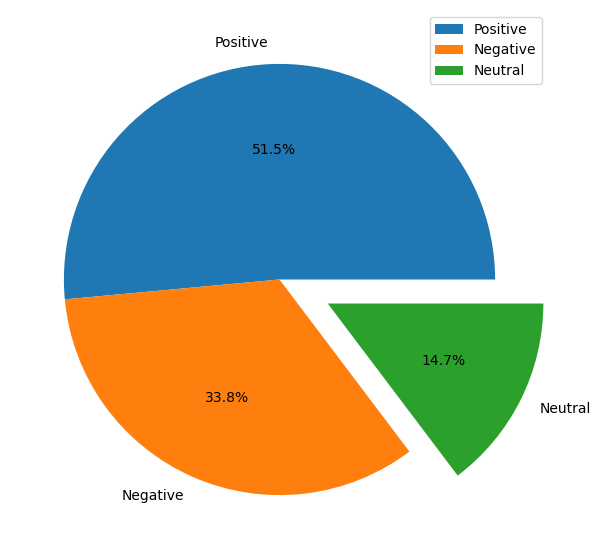

In [12]:
plt.figure(figsize=(10, 7))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.legend();

### VADER

VADER stands for Valence Aware Dictionary and Sentiment Reasoner. Vader sentiment not only tells if the statement is positive or negative along with the intensity of emotion.
The sum of pos, neg, neu intensities give 1. Compound ranges from -1 to 1 and is the metric used to draw the overall sentiment.
- positive if compound >= 0.5
- neutral if -0.5 < compound < 0.5
- negative if -0.5 >= compound

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
fin_data['Vader Sentiment'] = fin_data['Lemma'].apply(vadersentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
        
fin_data['Vader Analysis'] = fin_data['Vader Sentiment'].apply(vader_analysis)
fin_data.head()

,content,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,Positive,-0.6597,Negative
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,Negative,-0.2960,Neutral
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,Positive,0.5994,Positive
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...,0.600000,0.000000,Neutral,0.6597,Positive
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...,0.263333,0.003333,Positive,-0.2516,Neutral


In [14]:
vader_counts = fin_data['Vader Analysis'].value_counts()
vader_counts

Neutral     45
Positive    16
Negative     7
Name: Vader Analysis, dtype: int64

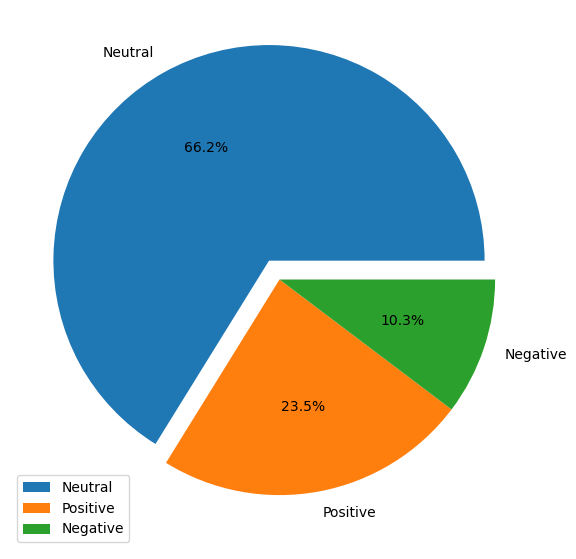

In [15]:
plt.figure(figsize=(10, 7))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
plt.legend();

### SentiWordNet

In [16]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"

fin_data['SWN analysis'] = filtered_allArticles['POS tagged'].apply(sentiwordnetanalysis)
fin_data.head()

[nltk_data] Downloading package sentiwordnet to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


,content,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,Positive,-0.6597,Negative,Neutral
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,Negative,-0.2960,Neutral,Negative
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,Positive,0.5994,Positive,Positive
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...,0.600000,0.000000,Neutral,0.6597,Positive,Positive
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...,0.263333,0.003333,Positive,-0.2516,Neutral,Positive


In [17]:
swn_counts= fin_data['SWN analysis'].value_counts()
swn_counts

Positive    36
Negative    27
Neutral      5
Name: SWN analysis, dtype: int64

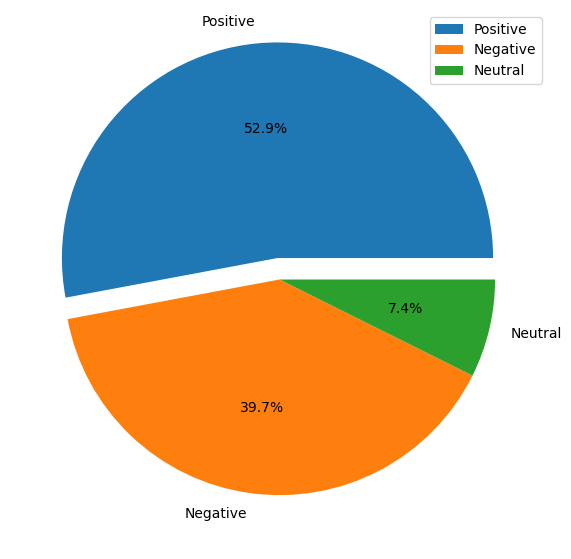

In [18]:
plt.figure(figsize=(10, 7))
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
plt.legend();

### Selection

In [19]:
for i in range(len(fin_data)):
    if fin_data['Analysis'][i] == 'Positive':
        fin_data['Analysis'][i] = 1
    elif fin_data['Analysis'][i] == 'Negative':
        fin_data['Analysis'][i] = -1
    else:
        fin_data['Analysis'][i] = 0

    if fin_data['Vader Analysis'][i] == 'Positive':
        fin_data['Vader Analysis'][i] = 1
    elif fin_data['Vader Analysis'][i] == 'Negative':
        fin_data['Vader Analysis'][i] = -1
    else:
        fin_data['Vader Analysis'][i] = 0

    if fin_data['SWN analysis'][i] == 'Positive':
        fin_data['SWN analysis'][i] = 1
    elif fin_data['SWN analysis'][i] == 'Negative':
        fin_data['SWN analysis'][i] = -1
    else:
        fin_data['SWN analysis'][i] = 0

fin_data['finalSentiment'] = [0] * len(fin_data)
for i in range(len(fin_data)):
    fin_data['finalSentiment'][i] = fin_data['Analysis'][i] + fin_data['Vader Analysis'][i] + fin_data['SWN analysis'][i]

fin_data['Res'] = fin_data['finalSentiment']
for i in range(len(fin_data)):
    if fin_data['finalSentiment'][i] == 3:
        fin_data['Res'][i] = 'Strong Positive'
    elif fin_data['finalSentiment'][i] == 2:
        fin_data['Res'][i] = 'Positive'
    elif -1 <= fin_data['finalSentiment'][i] <= 1:
        fin_data['Res'][i] = 'Neutral'
    elif fin_data['finalSentiment'][i] == -2:
        fin_data['Res'][i] = 'Negative'
    elif fin_data['finalSentiment'][i] == -3:
        fin_data['Res'][i] = 'Stong Negative'

fin_data.head(3)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\950749786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_data['Analysis'][i] = 1
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\950749786.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_data['Vader Analysis'][i] = -1
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\950749786.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_data['SWN 

,content,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis,finalSentiment,Res
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,1,-0.6597,-1,0,0,Neutral
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,-1,-0.2960,0,-1,-2,Negative
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,1,0.5994,1,1,3,Strong Positive


In [20]:
fin_data.to_csv('fin_data.csv', index=False, header=True)

In [21]:
fin_data

,content,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis,finalSentiment,Res
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,1,-0.6597,-1,0,0,Neutral
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,-1,-0.2960,0,-1,-2,Negative
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,1,0.5994,1,1,3,Strong Positive
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...,0.600000,0.000000,0,0.6597,1,1,2,Positive
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...,0.263333,0.003333,1,-0.2516,0,1,2,Positive
...,...,...,...,...,...,...,...,...,...,...
63,The worlds biggest central banks will this wee...,world big central bank week wrap aggressive ...,0.250000,-0.100000,-1,-0.0516,0,1,0,Neutral
64,"Stubbornly high inflation, soaring borrowing c...",stubbornly high inflation soar borrowing cos...,0.151667,0.040000,1,-0.5859,-1,-1,-1,Neutral
65,Australias central bank is playing with fire i...,australias central bank play fire signal hig...,0.385000,-0.010000,-1,0.2960,0,0,-1,Neutral
66,Annie Taylor was about to drop $100 on a new p...,annie taylor drop 100 new pair steve madden ...,0.260606,-0.015152,-1,-0.2732,0,1,0,Neutral


### Visualization

### Sentiment Scores for Inflation News

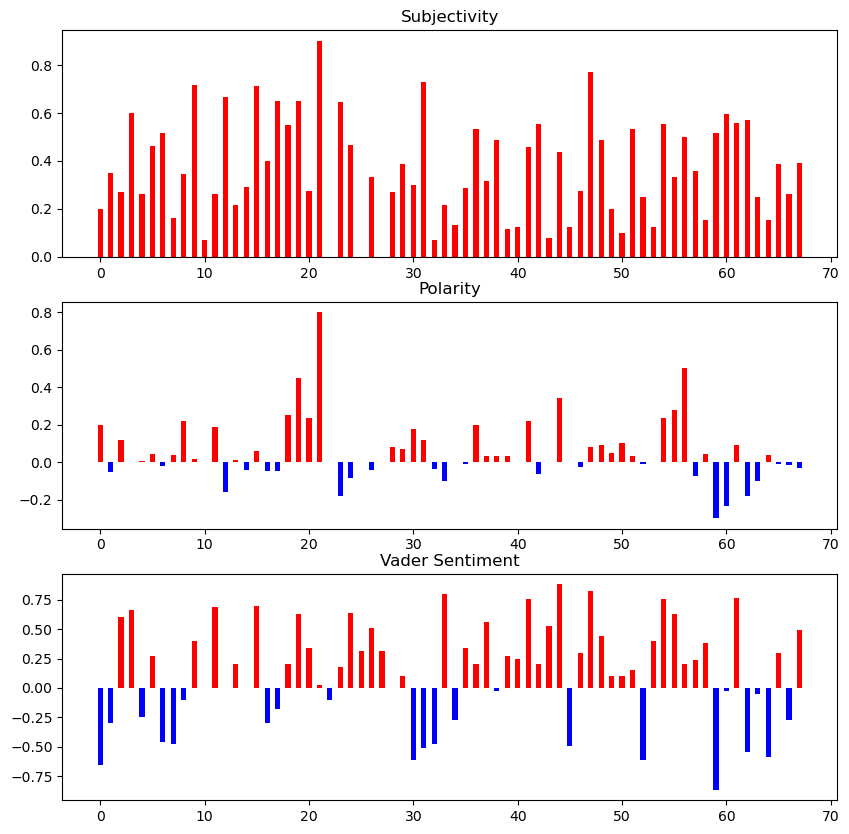

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

plt.close('all')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.2})
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.subplot(111)    # The big subplot
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
ax1.bar(fin_data[fin_data['Subjectivity'] > 0]['Subjectivity'].index, fin_data[fin_data['Subjectivity'] > 0]['Subjectivity'], width = 0.5, color='r')
ax1.bar(fin_data[fin_data['Subjectivity'] < 0]['Subjectivity'].index, fin_data[fin_data['Subjectivity'] < 0]['Subjectivity'], width=0.5, color='b')
ax2.bar(fin_data[fin_data['Polarity'] > 0]['Polarity'].index, fin_data[fin_data['Polarity'] > 0]['Polarity'], width = 0.5, color='r')
ax2.bar(fin_data[fin_data['Polarity'] < 0]['Polarity'].index, fin_data[fin_data['Polarity'] < 0]['Polarity'], width = 0.5, color='b')
ax3.bar(fin_data[fin_data['Vader Sentiment'] > 0]['Vader Sentiment'].index, fin_data[fin_data['Vader Sentiment'] > 0]['Vader Sentiment'], width=0.5, color='r')
ax3.bar(fin_data[fin_data['Vader Sentiment'] < 0]['Vader Sentiment'].index, fin_data[fin_data['Vader Sentiment'] < 0]['Vader Sentiment'], width=0.5, color='b')

# Set common labels
ax.set_xlabel('News')
ax.set_ylabel('Score')

ax1.set_title('Subjectivity')
ax2.set_title('Polarity')
ax3.set_title('Vader Sentiment')

plt.savefig('Sentiment Scores for Inflation News.png', dpi=300);

### Time series chart of rolling 5 period mean of Vader Sentiment


In [78]:
vader_rolling_df = pd.DataFrame({'Vader Sentiment': fin_data['Vader Sentiment'], 'PublishedAt': filtered_allArticles['publishedAt']})
vader_rolling_df

,Vader Sentiment,PublishedAt
0,-0.6597,2022-12-05T12:00:14Z
1,-0.2960,2022-12-13T12:00:16Z
2,0.5994,2022-12-16T12:00:16Z
3,0.6597,2022-12-15T11:30:18Z
4,-0.2516,2022-12-19T09:00:17Z
...,...,...
63,-0.0516,2022-12-10T22:06:06Z
64,-0.5859,2022-12-21T05:55:57Z
65,0.2960,2022-12-01T04:38:01Z
66,-0.2732,2022-12-20T16:16:17Z


In [79]:
new_format = "%Y-%m-%d"
for i in range(len(vader_rolling_df)):
    vader_rolling_df['PublishedAt'][i] = datetime.strptime(vader_rolling_df['PublishedAt'][i], "%Y-%m-%dT%H:%M:%SZ")  # "%Y-%m-%dT%H:%M:%SZ"
    vader_rolling_df['PublishedAt'][i] = vader_rolling_df['PublishedAt'][i].strftime(new_format)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\2567795267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_rolling_df['PublishedAt'][i] = datetime.strptime(vader_rolling_df['PublishedAt'][i], "%Y-%m-%dT%H:%M:%SZ")  # "%Y-%m-%dT%H:%M:%SZ"
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\2567795267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_rolling_df['PublishedAt'][i] = vader_rolling_df['PublishedAt'][i].strftime(new_format)


In [80]:
vader_rolling_df = vader_rolling_df.sort_values('PublishedAt').reset_index(drop=True)
vader_rolling_df

,Vader Sentiment,PublishedAt
0,0.7964,2022-11-29
1,0.1027,2022-11-30
2,0.5574,2022-11-30
3,-0.4767,2022-11-30
4,0.2960,2022-12-01
...,...,...
63,0.1027,2022-12-23
64,-0.0258,2022-12-23
65,0.2023,2022-12-23
66,0.0000,2022-12-23


In [81]:
vader_rolling_group = vader_rolling_df.groupby('PublishedAt')['Vader Sentiment'].sum().rolling(5).mean()
vader_rolling_group_df = pd.DataFrame({'PublishedAt':vader_rolling_group.index, 'Rolling Mean Score':vader_rolling_group.values})
vader_rolling_group_df

,PublishedAt,Rolling Mean Score
0,2022-11-29,NaN
1,2022-11-30,NaN
2,2022-12-01,NaN
3,2022-12-02,NaN
4,2022-12-03,0.26522
5,2022-12-04,0.15282
6,2022-12-05,-0.01580
7,2022-12-06,0.05190
8,2022-12-07,0.13660
9,2022-12-08,0.44446


In [83]:
vader_rolling_plot = vader_rolling_df.groupby('PublishedAt')['Vader Sentiment'].sum()
vader_rolling_plot_df = pd.DataFrame({'PublishedAt':vader_rolling_plot.index, 'Daily Score':vader_rolling_plot.values})
vader_rolling_plot_df

,PublishedAt,Daily Score
0,2022-11-29,0.7964
1,2022-11-30,0.1834
2,2022-12-01,0.5322
3,2022-12-02,0.6830
4,2022-12-03,-0.8689
5,2022-12-04,0.2344
6,2022-12-05,-0.6597
7,2022-12-06,0.8707
8,2022-12-07,1.1065
9,2022-12-08,0.6704


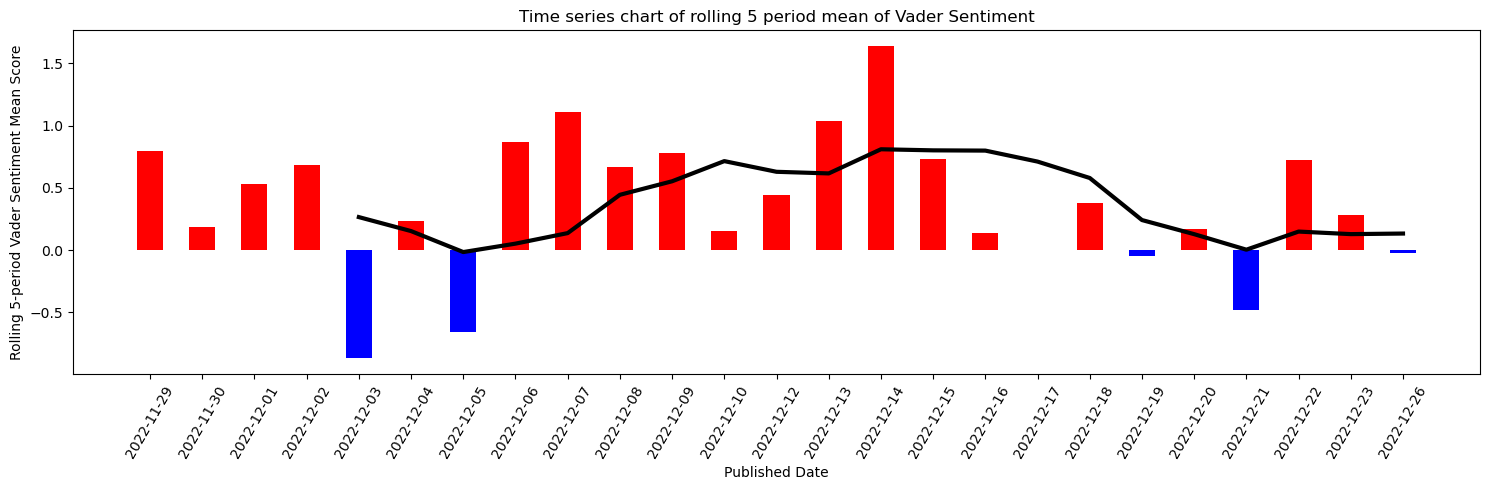

In [88]:
fig, ax = plt.subplots(1, 1, sharex=True, gridspec_kw={'hspace': 0})
fig.set_figheight(5)
fig.set_figwidth(15)
ax = plt.subplot(111)
ax.plot(vader_rolling_group_df['PublishedAt'], vader_rolling_group_df['Rolling Mean Score'], linewidth=3, color='black')
ax.bar(vader_rolling_plot_df[vader_rolling_plot_df['Daily Score'] > 0]['PublishedAt'], vader_rolling_plot_df[vader_rolling_plot_df['Daily Score'] > 0]['Daily Score'], width=0.5, color='r')
ax.bar(vader_rolling_plot_df[vader_rolling_plot_df['Daily Score'] < 0]['PublishedAt'], vader_rolling_plot_df[vader_rolling_plot_df['Daily Score'] < 0]['Daily Score'], width = 0.5, color='b')

# Set common labels
ax.set_xlabel('Published Date')
ax.set_ylabel('Rolling 5-period Vader Sentiment Mean Score')
ax.set_title('Time series chart of rolling 5 period mean of Vader Sentiment')
plt.xticks(rotation=60)
fig.set_tight_layout(True)
plt.savefig('Time series chart of rolling 5 period mean of Vader Sentiment.png', dpi=300);

## Part II: Twitter Analysis